## Demo code for "Dynamic 3D Gaze from Afar: Deep Gaze Estimation from Temporal Eye-Head-Body Coordinations"

In [56]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from models.gazenet import GazeNet
from dataloader.gafa import create_gafa_dataset

### Load pretrained model

In [57]:
model = GazeNet(n_frames=7)
model.load_state_dict(torch.load('./models/weights/gazenet_GAFA.pth', map_location='cpu')['state_dict'])
model.cuda()

GazeNet(
  (hbnet): HBNet(
    (featurenet): SharedFeatureNet(
      (stem): Sequential(
        (0): Conv2dStaticSamePadding(
          3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
          (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
        )
        (1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
    )
    (headnet): HeadNet(
      (head_branch): EfficientNet(
        (_conv_stem): Identity()
        (_bn0): Identity()
        (_blocks): ModuleList(
          (0): MBConvBlock(
            (_depthwise_conv): Conv2dStaticSamePadding(
              32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
              (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
            )
            (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (_se_reduce): Conv2dStaticSamePadding(
              32, 8, kernel_size=(1

### Load dataset


Our model takes body image, head position, body velocity as inputs. The following form of input is assumedWe assume following input. Note that our model revieves multiple frames and estimates gaze direction for each frame. 
   - body image: Image capturing whole body of a person. torch.Tensor with the size of (number of frames x 3 (RGB channel) x 256 (image height) x 192 (image width))
   - head mask: Binary image indicating the head position of the person. torch.Tensor with the size of (number of frames x 1 x 256 x 192)
   - body velocity: 2D body velocity of body movement in image plane. torch.Tensor with the size of (number of frames x 2 (dx, dy))

Please see the preprocessing script for details [dataloader/gafa.py](dataloader/gafa.py).

In [58]:
sequence = ['living_room/006']

dataset = create_gafa_dataset(n_frames=7, exp_names=sequence, root_dir='./data/preprocessed/')

In [59]:
batch = dataset[0]

print(batch['image'].shape)
print(batch['head_mask'].shape)
print(batch['body_dv'].shape)

torch.Size([7, 3, 256, 192])
torch.Size([7, 1, 256, 192])
torch.Size([7, 2])


### Inference

In [60]:
image, head_mask, body_dv = batch['image'], batch['head_mask'], batch['body_dv']

with torch.no_grad():
    image = image.cuda().unsqueeze(0)
    head_mask = head_mask.cuda().unsqueeze(0)
    body_dv = body_dv.cuda().unsqueeze(0)
    gaze_res, head_res, body_res = model(image, head_mask, body_dv)

gaze_direction = gaze_res['direction'][0].cpu()
gaze_confidence = gaze_res['kappa'][0].cpu()

### Visualization

Plot the estimated gaze direction. Though the model estimates 3D gaze direction, we project it to the image plane and plot 2D gaze direction. 

In [61]:
gaze_dir_2d = gaze_direction[0, 0:2].numpy()
gaze_dir_2d /= np.linalg.norm(gaze_dir_2d)

In [62]:
def denormalize(image):
    return image.transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


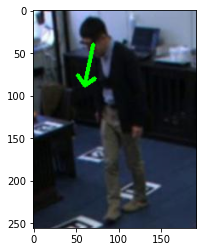

In [63]:
vis_image = denormalize(batch['image'].numpy()[0])
head_center_x = 70
head_center_y = 40
head_center = (int(head_center_x), int(head_center_y))
des = (head_center[0] + int(gaze_dir_2d[0]*50), int(head_center[1] + gaze_dir_2d[1]*50))

vis_image = cv2.arrowedLine(vis_image.copy(), head_center, des, (0, 255, 0), 3, tipLength=0.3)

plt.imshow(vis_image)
plt.show()